# News Mood Challenge

In [10]:
#import necessary modules and info
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

In [11]:
#authenticate tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [12]:
#compile list of twitter handles through which to loop
handles = ["@BBCNews", "@CBSNews", "@CNN", "@FoxNews", "@nytimes"]

#create a list to hold dictionaries of the sentiment analysis resules
s_scores = []

#create a variable to store the oldest tweet id for the loop
ot = None

In [13]:
#loop through the news organizations
for handle in handles:
    
    #create counter for tabulating tweets
    c = 1
    
    #loop through 5 pages (20 tweets per page) of tweets to acquire 100 tweets
    for x in range(5):
        tweets = api.user_timeline(handle, max_id = ot)
    
        #loop through the tweets themselves
        for t in tweets:
            
            #run Vader analysis on the tweet
            scores = analyzer.polarity_scores(t["text"])
            
            #add dictionary of scores to the list along with the media source date stamp
            s_scores.append({"Media Source": t["user"]["name"],
                            "Date": t["created_at"],
                           "Text": t["text"],
                           "Compound": scores["compound"],
                           "Positive": scores["pos"],
                           "Negative": scores["neu"],
                           "Neutral": scores["neg"],
                           "Tweets Ago": c})
            
            # store the tweet id in the oldest tweet variable and subtract 1 to continue iteration
            ot = t['id'] - 1
            
            #increase the counter to document the next tweet
            c += 1            

In [14]:
#convert the list of dictionaries containing the scores into a DataFrame
spd = pd.DataFrame(s_scores)
spd = spd[["Media Source", "Date", "Text", "Tweets Ago", "Compound", "Negative", "Neutral", "Positive"]]
spd.head()

,Media Source,Date,Text,Tweets Ago,Compound,Negative,Neutral,Positive
0,BBC News (UK),Fri Jul 27 16:53:00 +0000 2018,RT @BBCPanorama: Stockton-on-Tees is the town ...,1,-0.7906,0.731,0.269,0.000
1,BBC News (UK),Fri Jul 27 16:34:03 +0000 2018,📵 Get ready for Scroll Free September 📵\n\nhtt...,2,0.7003,0.463,0.000,0.537
2,BBC News (UK),Fri Jul 27 16:29:35 +0000 2018,Christine Lampard's stalker Christof King sent...,3,-0.0258,0.845,0.155,0.000
3,BBC News (UK),Fri Jul 27 16:16:02 +0000 2018,Drill music video stop and search by armed pol...,4,-0.2960,0.820,0.180,0.000
4,BBC News (UK),Fri Jul 27 16:09:52 +0000 2018,RT @BBCNewsbeat: The incident was described as...,5,0.0000,1.000,0.000,0.000


In [15]:
#export the DataFrame to a csv
spd.to_csv("100tweets_by_org.csv")

In [16]:
#add color coding into the the DataFrame by news organization
spd.loc[spd['Media Source'].str.contains('BBC'), 'source_key'] = 'gold'
spd.loc[spd['Media Source'].str.contains('CNN'), 'source_key'] = 'steelblue'
spd.loc[spd['Media Source'].str.contains('CBS'), 'source_key'] = 'seagreen'
spd.loc[spd['Media Source'].str.contains('Fox'), 'source_key'] = 'firebrick'
spd.loc[spd['Media Source'].str.contains('York'), 'source_key'] = 'slateblue'

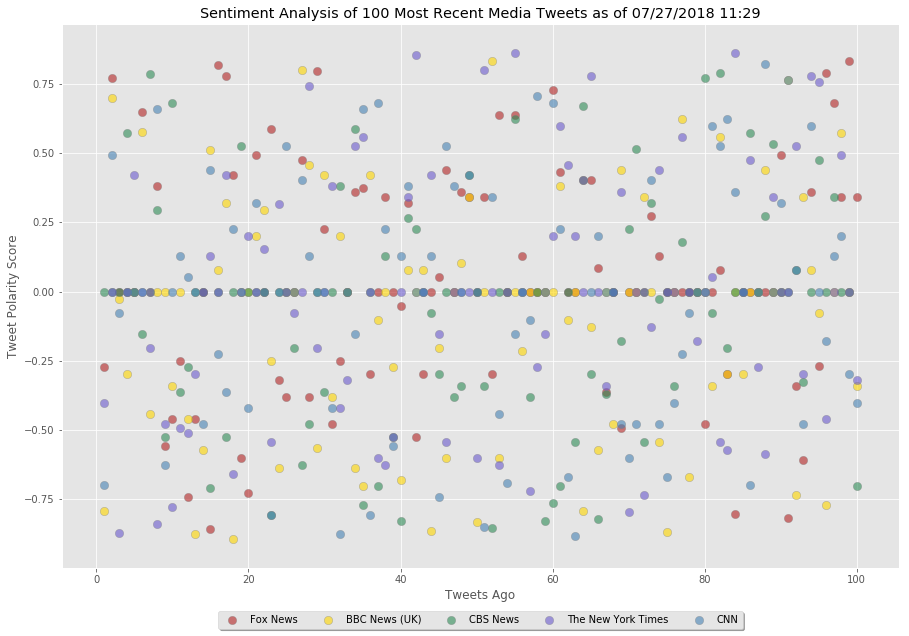

In [52]:
#get a datestamp in order to label the data
datestamp = datetime.now().strftime("%m/%d/%Y %H:%M")

#set plot size
plt.figure(figsize = (15, 10))

#iterate through color mapping to create a subplot per news source
for i, dff in spd.groupby('source_key'):
    plt.scatter(dff['Tweets Ago'], dff['Compound'], s=70, c=i, edgecolors='grey', alpha=0.6, label=dff['Media Source'].unique()[0])

#set legend below the axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
          fancybox=True, shadow=True, ncol=5)

#label the data
plt.title(f"Sentiment Analysis of 100 Most Recent Media Tweets as of {datestamp}")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity Score")

#save figure
plt.savefig('100_tweets_sentiments.png')
# show plot
plt.show()